NOTE : Untuk Run testing Predik harus mulai dari awal dan lewati bagian Build Model dan Testing Akurasi

# **LIBRARY**

In [1]:
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
import tensorflow as tf
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
import re
import string
import nltk
nltk.download('stopwords')
sns.despine()
plt.style.use("fivethirtyeight")
sns.set_style("darkgrid")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<Figure size 640x480 with 0 Axes>

In [2]:
#check tensorflow version
print(tf.__version__)

#matplotlib version
print(mpl.__version__)

#pandas version
print(pd. __version__)

#numpy version
print(np. __version__)

#seaborn version
print(sns. __version__)

#python version
!python --version

2.15.0
3.7.1
1.5.3
1.23.5
0.12.2
Python 3.10.12


In [3]:
pip install openpyxl

# **READ DATASET**

In [8]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
dv = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Bangkit/DATASETS GABUNGAN BULLIENCE - Dataset Violence.csv")
dv

,Teks,Label
0,selamat sore saya adalah ibu dari satu anak sa...,Violence
1,mohon bantu pak saya sedang hamil pak diluar n...,Non-Violence
2,saya seorang anak perempuan yang bersuami teta...,Violence
3,jika anak perempuan tidak di beri nafkah orang...,Non-Violence
4,pak saya status pernikahan sudah setahun pisah...,Violence
...,...,...
201,Kami bersama-sama membangun program mentorship...,Non-Violence
202,"Dalam menjalani kehidupan sehari-hari, kami be...",Non-Violence
203,Melibatkan generasi muda dalam kegiatan positi...,Non-Violence
204,Kami aktif dalam kampanye keamanan jalan raya ...,Non-Violence


# **DATA PREPROCESSING**

In [10]:
dv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    206 non-null    object
 1   Label   206 non-null    object
dtypes: object(2)
memory usage: 3.3+ KB


In [11]:
# Checking for null values
dv.isnull().values.any()

False

In [12]:
# Melihat jumlah masing-masing tipe
dv['Label'].value_counts()

Violence        103
Non-Violence    103
Name: Label, dtype: int64

Counter({'Violence': 103, 'Non-Violence': 103})


<Axes: xlabel='Label', ylabel='count'>

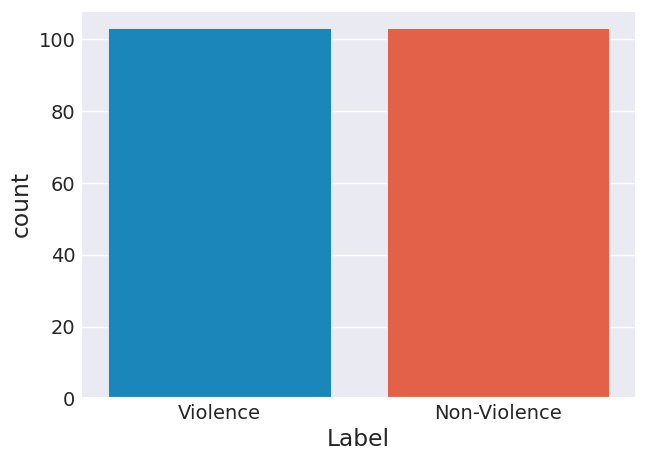

In [13]:
# Distribusi Target
x = dv.Teks
y = dv.Label

from collections import Counter

print(Counter(y))
sns.countplot(x=y)

count    103.000000
mean      22.126214
std       11.981751
min        6.000000
25%       15.000000
50%       21.000000
75%       25.000000
max       94.000000
Name: Length, dtype: float64

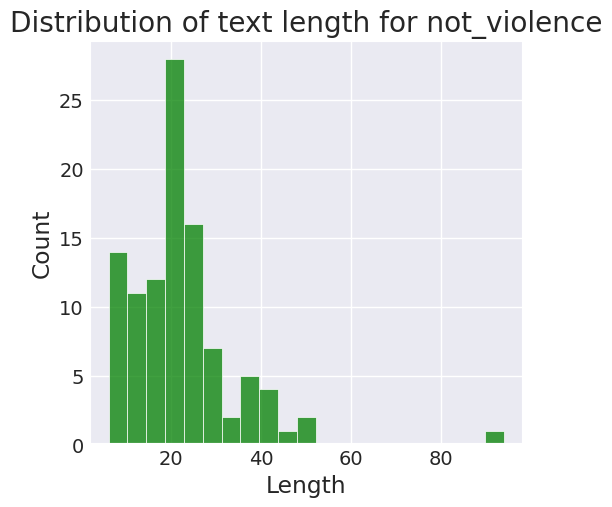

In [14]:
# Melihat statistical description serta histogram panjang teks Non-B
dv["Length"] = dv.Teks.str.split().apply(len)
plt.figure(figsize=(5,5))
sns.histplot(dv[dv["Label"]=="Non-Violence"]['Length'],color="g")
plt.title("Distribution of text length for not_violence")
display(dv.Length[dv["Label"]=="Non-Violence"].describe())

count    103.000000
mean      17.631068
std       13.782619
min        4.000000
25%        8.500000
50%       14.000000
75%       20.000000
max       77.000000
Name: Length, dtype: float64

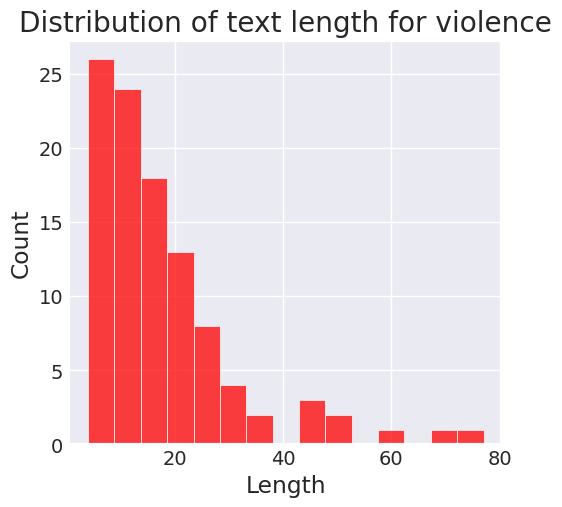

In [15]:
# Melihat statistical description serta histogram panjang teks B
dv["Length"] = dv.Teks.str.split().apply(len)
plt.figure(figsize=(5,5))
sns.histplot(dv[dv["Label"]=="Violence"]['Length'],color="r")
plt.title("Distribution of text length for violence")
display(dv.Length[dv["Label"]=="Violence"].describe())

In [16]:
# variabel untuk kolom teks
texts = dv.Teks
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [17]:
# Case Folding
# gunakan fungsi series.str.lower() pada Pandas
texts = texts.str.lower()

print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [18]:
def remove_special_signs(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

texts = texts.apply(remove_special_signs)
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [19]:
#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

texts = texts.apply(remove_number)
texts.head(5)

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object

In [20]:
# remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

texts = texts.apply(remove_punctuation)
texts.head(5)

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object

In [21]:
#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

texts = texts.apply(remove_whitespace_LT)
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [22]:
# remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

texts = texts.apply(remove_whitespace_multiple)
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [23]:
# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

texts = texts.apply(remove_singl_char)
print(texts.head())

0    selamat sore saya adalah ibu dari satu anak sa...
1    mohon bantu pak saya sedang hamil pak diluar n...
2    saya seorang anak perempuan yang bersuami teta...
3    jika anak perempuan tidak di beri nafkah orang...
4    pak saya status pernikahan sudah setahun pisah...
Name: Teks, dtype: object


In [24]:
# Filtering - Stopword Removal
from nltk.corpus import stopwords
# Get Indonesian stopwords
list_stopwords = stopwords.words('indonesian')

# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja',
                       'nyg', 'hehe', 'pen', 'nan', 'loh',
                       '&amp', 'yah',])

# read txt stopword using pandas
csv_stopword = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Bangkit/stopwordsID.csv")

# convert stopword string to list & append additional stopword
list_stopwords.extend(csv_stopword)

# convert list to dictionary
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

texts = texts.apply(stopwords_removal)


print(texts.head())

0    [s, e, l, a, m, a, t,  , s, o, r, e,  , s, a, ...
1    [m, o, h, o, n,  , b, a, n, t, u,  , p, a, k, ...
2    [s, a, y, a,  , s, e, o, r, a, n, g,  , a, n, ...
3    [j, i, k, a,  , a, n, a, k,  , p, e, r, e, m, ...
4    [p, a, k,  , s, a, y, a,  , s, t, a, t, u, s, ...
Name: Teks, dtype: object


In [25]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('indonesian'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

dv['Teks'] = dv['Teks'].apply(normalize_text)

In [26]:
# convert the categorical values to numeric using the factorize() method. This returns an array of numeric values and an Index of categories.
# Inisialisasi variabel target
y = dv["Label"]
#mengubah y menjadi integer
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)
print(y)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 

In [27]:
# Menghitung jumlah value integer sentimen
dv["Label"].value_counts()

Violence        103
Non-Violence    103
Name: Label, dtype: int64

In [28]:
# replace label pada dataset
dv.Label.replace("Violence", 1 , inplace = True)
dv.Label.replace("Non-Violence", 0 , inplace = True)
dv.head(10)

,Teks,Label,Length
0,selamat sore anak janda mantan suami menganiay...,1,27
1,mohon bantu hamil diluar nikah anak kembar pac...,0,42
2,anak perempuan bersuami orang tua campur ayah ...,1,27
3,anak perempuan nafkah orang tua nya lakukan an...,0,24
4,status pernikahan setahun pisah ranjang pernik...,1,77
5,ayah melarang anak bertemu nya dilarang merawa...,0,21
6,bercerai tujuh ngga nafkah anak kemana bantuan,0,17
7,anak anak ditelantarkan perantauan suami bawa ...,1,62
8,lakukan perlindungan perempuan suami menyiksa ...,1,14
9,tolong perlindungan pencemaran nama anak ancam...,1,20


In [29]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

dv['Teks'] = dv['Teks'].apply(normalize_text)

In [30]:
# Tokenisasi dan stemming
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in tokens]
    return stems

# Contoh pemisahan dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(dv['Teks'], dv['Label'], test_size=0.2, random_state=42)

max_words = 100  # Jumlah kata unik yang akan diambil
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

stemmer = PorterStemmer()
X_train_stemmed = [' '.join([stemmer.stem(word) for word in text.split()]) for text in X_train]
X_test_stemmed = [' '.join([stemmer.stem(word) for word in text.split()]) for text in X_test]

X_train_sequences = tokenizer.texts_to_sequences(X_train_stemmed)
X_test_sequences = tokenizer.texts_to_sequences(X_test_stemmed)

max_sequence_length = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')


# **BUILD A MODEL**

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=16, input_length=max_sequence_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 16)            1600      
                                                                 
 flatten (Flatten)           (None, 720)               0         
                                                                 
 dense (Dense)               (None, 64)                46144     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 47809 (186.75 KB)
Trainable params: 47809 (186.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test))

Epoch 1/10
6/6 [==============================] - 1s 54ms/step - loss: 0.6920 - accuracy: 0.4878 - val_loss: 0.6863 - val_accuracy: 0.7143
Epoch 2/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6771 - accuracy: 0.7073 - val_loss: 0.6775 - val_accuracy: 0.6667
Epoch 3/10
6/6 [==============================] - 0s 12ms/step - loss: 0.6638 - accuracy: 0.6890 - val_loss: 0.6678 - val_accuracy: 0.6905
Epoch 4/10
6/6 [==============================] - 0s 9ms/step - loss: 0.6464 - accuracy: 0.7256 - val_loss: 0.6520 - val_accuracy: 0.6667
Epoch 5/10
6/6 [==============================] - 0s 12ms/step - loss: 0.6273 - accuracy: 0.7195 - val_loss: 0.6441 - val_accuracy: 0.6905
Epoch 6/10
6/6 [==============================] - 0s 15ms/step - loss: 0.6069 - accuracy: 0.7134 - val_loss: 0.6372 - val_accuracy: 0.7381
Epoch 7/10
6/6 [==============================] - 0s 13ms/step - loss: 0.5856 - accuracy: 0.7012 - val_loss: 0.6143 - val_accuracy: 0.6667
Epoch 8/10
6/6 [=============

In [34]:
model.fit(X_train_padded, y_train, epochs=20, validation_data=(X_test_padded, y_test))

Epoch 1/20
6/6 [==============================] - 0s 27ms/step - loss: 0.4883 - accuracy: 0.7744 - val_loss: 0.5663 - val_accuracy: 0.7381
Epoch 2/20
6/6 [==============================] - 0s 9ms/step - loss: 0.4589 - accuracy: 0.7805 - val_loss: 0.5656 - val_accuracy: 0.7619
Epoch 3/20
6/6 [==============================] - 0s 12ms/step - loss: 0.4459 - accuracy: 0.7988 - val_loss: 0.5488 - val_accuracy: 0.7619
Epoch 4/20
6/6 [==============================] - 0s 13ms/step - loss: 0.4113 - accuracy: 0.8232 - val_loss: 0.5627 - val_accuracy: 0.6905
Epoch 5/20
6/6 [==============================] - 0s 9ms/step - loss: 0.3857 - accuracy: 0.8537 - val_loss: 0.5307 - val_accuracy: 0.7381
Epoch 6/20
6/6 [==============================] - 0s 12ms/step - loss: 0.3584 - accuracy: 0.8598 - val_loss: 0.5208 - val_accuracy: 0.7381
Epoch 7/20
6/6 [==============================] - 0s 9ms/step - loss: 0.3360 - accuracy: 0.8780 - val_loss: 0.5124 - val_accuracy: 0.6667
Epoch 8/20
6/6 [==============

# **TEST AKURASI**

In [35]:
from sklearn.metrics import accuracy_score

In [36]:
# Melakukan prediksi pada data uji
predictions = model.predict(X_test_padded)

# Thresholding untuk mengubah nilai probabilitas menjadi label biner (0 atau 1)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Evaluasi model
accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy}')


2/2 [==============================] - 0s 10ms/step
Accuracy: 0.8095238095238095


Epoch 1/10
6/6 [==============================] - 0s 29ms/step - loss: 0.1096 - accuracy: 0.9817 - val_loss: 0.4591 - val_accuracy: 0.7143
Epoch 2/10
6/6 [==============================] - 0s 16ms/step - loss: 0.1013 - accuracy: 0.9878 - val_loss: 0.4431 - val_accuracy: 0.8333
Epoch 3/10
6/6 [==============================] - 0s 16ms/step - loss: 0.0899 - accuracy: 0.9878 - val_loss: 0.4436 - val_accuracy: 0.8333
Epoch 4/10
6/6 [==============================] - 0s 18ms/step - loss: 0.0883 - accuracy: 0.9878 - val_loss: 0.4488 - val_accuracy: 0.8095
Epoch 5/10
6/6 [==============================] - 0s 16ms/step - loss: 0.0835 - accuracy: 0.9878 - val_loss: 0.4362 - val_accuracy: 0.8095
Epoch 6/10
6/6 [==============================] - 0s 14ms/step - loss: 0.0733 - accuracy: 0.9878 - val_loss: 0.4317 - val_accuracy: 0.8095
Epoch 7/10
6/6 [==============================] - 0s 17ms/step - loss: 0.0680 - accuracy: 0.9878 - val_loss: 0.4375 - val_accuracy: 0.8095
Epoch 8/10
6/6 [===========

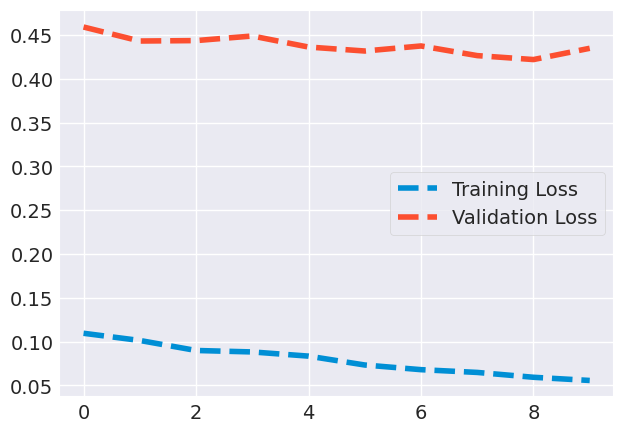

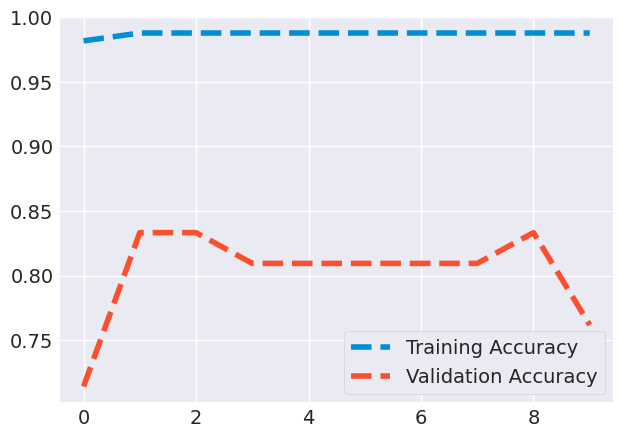

In [37]:
import matplotlib.pyplot as plt

history = model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_test_padded, y_test))

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [38]:
from sklearn.metrics import accuracy_score, classification_report

# Melakukan prediksi pada data uji
predictions = model.predict(X_test_padded)

# Menggunakan threshold untuk mengubah nilai probabilitas menjadi label biner (0 atau 1)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

# Evaluasi model
accuracy = accuracy_score(y_test, predicted_labels)
print(f'Accuracy: {accuracy}')

# Classification Report
print(classification_report(y_test, predicted_labels))


2/2 [==============================] - 0s 6ms/step
Accuracy: 0.7619047619047619
              precision    recall  f1-score   support

           0       0.85      0.71      0.77        24
           1       0.68      0.83      0.75        18

    accuracy                           0.76        42
   macro avg       0.77      0.77      0.76        42
weighted avg       0.78      0.76      0.76        42



In [41]:
import joblib

In [39]:
#joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(max_sequence_length, 'max_sequence_length.pkl')

['max_sequence_length.pkl']

In [ ]:
# Menyimpan model
model.save('model_violence.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **TESTING MODEL PREDIK**

In [4]:
model = load_model('Model_Violence.h5')

In [40]:
import joblib

# Fungsi untuk mendapatkan kategori berdasarkan range persentase
def get_category(percentage):
    if percentage < 0.33:
        return 'Ringan'
    elif 0.33 <= percentage < 0.67:
        return 'Sedang'
    else:
        return 'Berat'

# Fungsi untuk membuat prediksi dan menampilkan hasilnya
def predict_and_display(model, text, threshold=0.5):
    # Tokenisasi dan stemming pada teks
    stemmer = joblib.load('stemmer.pkl')
    text_stemmed = ' '.join([stemmer.stem(word) for word in text.split()])
    tokenizer = joblib.load('tokenizer.pkl')
    text_sequence = tokenizer.texts_to_sequences([text_stemmed])
    max_sequence_length = joblib.load('max_sequence_length.pkl')
    text_padded = pad_sequences(text_sequence, maxlen=max_sequence_length, padding='post', truncating='post')

   # Prediksi menggunakan model
    predictions = model.predict(text_padded)[0]  # Hapus indeks [0]

    # Ambil indeks kelas dengan nilai tertinggi
    predicted_index = np.argmax(predictions)

   # Tentukan hasil prediksi berdasarkan threshold
    predicted_label = "Violence" if predictions[predicted_index] > threshold else "Non-Violence"

    # Menampilkan hasil prediksi
    confidence = predictions[predicted_index] * 100
    category = get_category(confidence / 100)  # Konversi persentase ke range 0-1

    print(f'Teks: {text}')
    print(f'Prediksi: {predicted_label}')
    print(f'Persentase: {confidence:.2f}%')
    print(f'Kategori: {category}')
    print()

# # Contoh data teks untuk pengujian
# test_texts = ["aku melihat teman saya dibully sampe kena mental.", "Contoh teks 2 untuk pengujian."]

# # Melakukan pengujian model
# test_model(model, test_texts)

# Contoh pengujian
texts_to_test = [
    "Saya ditolong seorang pria ramah.",
    "Saya sangat kecewa dengan produk yang saya beli, kualitasnya sangat buruk.",
    "Film ini benar-benar luar biasa, saya sangat menikmati setiap momennya.",
    "Pelayanan pelanggan sangat ramah dan membantu.",
    "Saya sedang diperkosa adik dengan keras",
    "Sangat kecewa dengan produk ini.",
    "Teks positif yang sangat bagus.",
    "saya melihat sebuah kekerasan yang dilakukan suami kepada istri"
]

# Lakukan prediksi untuk setiap teks
for text_to_test in texts_to_test:
    predict_and_display(model, text_to_test)

# Menyimpan model dan tokenizer (vectorizer)
#model.save('text_classification_model.h5')
#joblib.dump(tokenizer, 'tokenizer.joblib')


1/1 [==============================] - 0s 24ms/step
Teks: Saya ditolong seorang pria ramah.
Prediksi: Non-Violence
Persentase: 49.79%
Kategori: Sedang

1/1 [==============================] - 0s 24ms/step
Teks: Saya sangat kecewa dengan produk yang saya beli, kualitasnya sangat buruk.
Prediksi: Non-Violence
Persentase: 12.71%
Kategori: Ringan

1/1 [==============================] - 0s 25ms/step
Teks: Film ini benar-benar luar biasa, saya sangat menikmati setiap momennya.
Prediksi: Non-Violence
Persentase: 12.71%
Kategori: Ringan

1/1 [==============================] - 0s 27ms/step
Teks: Pelayanan pelanggan sangat ramah dan membantu.
Prediksi: Violence
Persentase: 50.70%
Kategori: Sedang

1/1 [==============================] - 0s 27ms/step
Teks: Saya sedang diperkosa adik dengan keras
Prediksi: Violence
Persentase: 79.54%
Kategori: Berat

1/1 [==============================] - 0s 25ms/step
Teks: Sangat kecewa dengan produk ini.
Prediksi: Non-Violence
Persentase: 49.79%
Kategori: Sedang



In [ ]:
model.save('Model_Violence.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
